### Imports

In [1]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

### Ground truth map mesh

In [2]:
verts, faces, aux = load_obj(os.path.join('../data/meshes/simple_cave_01.obj'))
# verts, faces, aux = load_obj(os.path.join('/home/ruslan/CTU/thirdparty/pytorch3d/docs/tutorials/dolphin.obj'))

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We construct a Meshes structure for the target mesh
mesh = Meshes(verts=[verts], faces=[faces_idx])

### Point cloud to compare

In [3]:
def plot_pointcloud(inputs, title=""):
    assert isinstance(inputs, Meshes) or isinstance(inputs, Pointclouds) or isinstance(inputs, torch.Tensor)
    if isinstance(inputs, Meshes):
        # Sample points uniformly from the surface of the mesh.
        points = sample_points_from_meshes(inputs, 5000)
    elif isinstance(inputs, Pointclouds):
        points = inputs.points_list()[0]
    elif isinstance(inputs, torch.Tensor):
        points = inputs
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [4]:
# points = sample_points_from_meshes(map_gt_mesh, 5000)
points = verts[None][:, torch.randint(verts.shape[0], (5000,)), :]
pcl = Pointclouds(points)

<IPython.core.display.Javascript object>


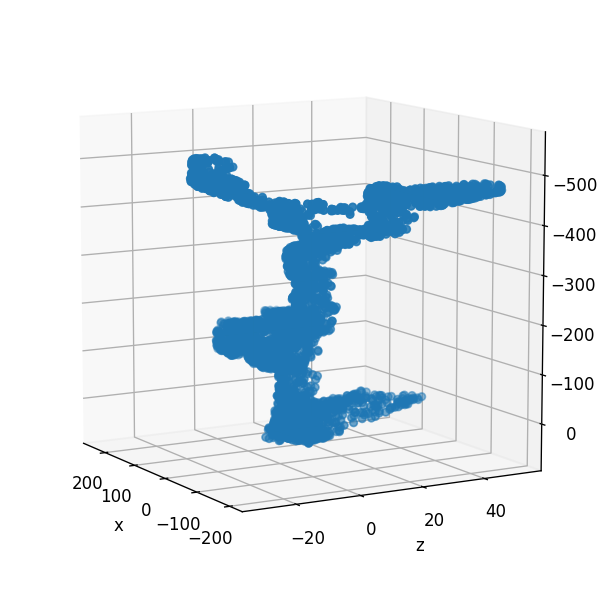

In [5]:
plot_pointcloud(mesh)

<IPython.core.display.Javascript object>


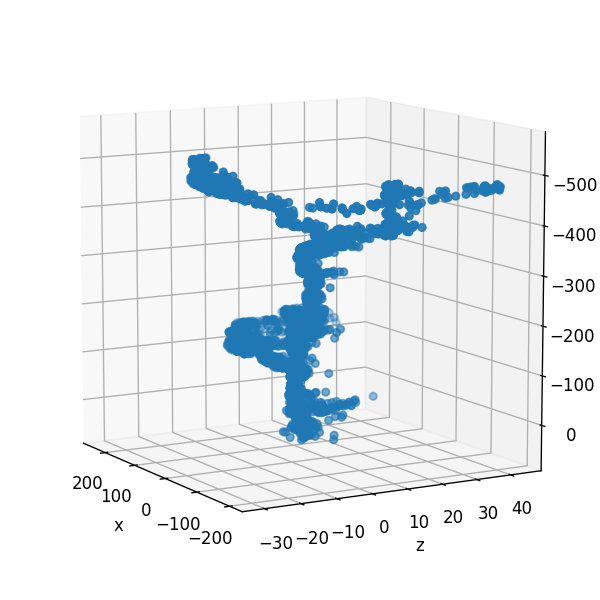

In [6]:
plot_pointcloud(pcl)

### Compare mesh to point cloud

In [7]:
# Compare mesh and point cloud:
# https://pytorch3d.readthedocs.io/en/latest/modules/loss.html#pytorch3d.loss.point_mesh_edge_distance
from pytorch3d.loss import point_mesh_edge_distance, point_mesh_face_distance
from rpz_planning import point_face_distance_truncated
from rpz_planning import point_edge_distance_truncated
from rpz_planning import face_point_distance_truncated
from rpz_planning import edge_point_distance_truncated
from rpz_planning import chamfer_distance_truncated

In [11]:
# point cloud is simply obtained from mesh vertices
with torch.no_grad():
    for s in range(5000, 50001, 5000):
        points = verts[None][:, torch.randint(verts.shape[0], (s,)), :]
        pcl = Pointclouds(points)
        # plot_pointcloud(pcl)
        print('Num sampled points:', s)
        print('EP:', edge_point_distance_truncated(meshes=mesh, pcls=pcl))
        print('PE:', point_edge_distance_truncated(meshes=mesh, pcls=pcl))
        print('EPPE:', point_mesh_edge_distance(meshes=mesh, pcls=pcl).sqrt())
        print('\n')

        print('FP:', face_point_distance_truncated(meshes=mesh, pcls=pcl))
        print('PF:', point_face_distance_truncated(meshes=mesh, pcls=pcl))
        print('FPPF:', point_mesh_face_distance(meshes=mesh, pcls=pcl).sqrt())
        print('-'*30)

Num sampled points: 5000
EP: tensor(0.9853, device='cuda:0')
PE: tensor(7.4506e-13, device='cuda:0')
EPPE: tensor(1.5201, device='cuda:0')


FP: tensor(0.9254, device='cuda:0')
PF: tensor(2.7643e-11, device='cuda:0')
FPPF: tensor(1.4428, device='cuda:0')
------------------------------
Num sampled points: 10000
EP: tensor(0.6914, device='cuda:0')
PE: tensor(3.7253e-13, device='cuda:0')
EPPE: tensor(1.0874, device='cuda:0')


FP: tensor(0.6335, device='cuda:0')
PF: tensor(2.1166e-11, device='cuda:0')
FPPF: tensor(1.0127, device='cuda:0')
------------------------------
Num sampled points: 15000
EP: tensor(0.5570, device='cuda:0')
PE: tensor(6.2088e-13, device='cuda:0')
EPPE: tensor(0.8872, device='cuda:0')


FP: tensor(0.5006, device='cuda:0')
PF: tensor(3.0735e-11, device='cuda:0')
FPPF: tensor(0.8141, device='cuda:0')
------------------------------
Num sampled points: 20000
EP: tensor(0.4798, device='cuda:0')
PE: tensor(3.7253e-13, device='cuda:0')
EPPE: tensor(0.7752, device='cuda:0')


In [10]:
# point cloud is sampled from mesh surface
with torch.no_grad():
    for s in range(5000, 50001, 5000):
        points = sample_points_from_meshes(mesh, s)
        pcl = Pointclouds(points)
        # plot_pointcloud(pcl)
        print('Num sampled points:', s)
        print('EP:', edge_point_distance_truncated(meshes=mesh, pcls=pcl))
        print('PE:', point_edge_distance_truncated(meshes=mesh, pcls=pcl))
        print('EPPE:', point_mesh_edge_distance(meshes=mesh, pcls=pcl).sqrt())
        print('\n')

        print('FP:', face_point_distance_truncated(meshes=mesh, pcls=pcl))
        print('PF:', point_face_distance_truncated(meshes=mesh, pcls=pcl))
        print('FPPF:', point_mesh_face_distance(meshes=mesh, pcls=pcl).sqrt())
        print('-'*30)

Num sampled points: 5000
EP: tensor(1.4649, device='cuda:0')
PE: tensor(0.2005, device='cuda:0')
EPPE: tensor(1.6960, device='cuda:0')


FP: tensor(1.4114, device='cuda:0')
PF: tensor(3.5622e-06, device='cuda:0')
FPPF: tensor(1.6138, device='cuda:0')
------------------------------
Num sampled points: 10000
EP: tensor(1.0752, device='cuda:0')
PE: tensor(0.2010, device='cuda:0')
EPPE: tensor(1.2694, device='cuda:0')


FP: tensor(1.0241, device='cuda:0')
PF: tensor(3.5468e-06, device='cuda:0')
FPPF: tensor(1.1795, device='cuda:0')
------------------------------
Num sampled points: 15000
EP: tensor(0.8712, device='cuda:0')
PE: tensor(0.2012, device='cuda:0')
EPPE: tensor(1.0500, device='cuda:0')


FP: tensor(0.8211, device='cuda:0')
PF: tensor(3.5452e-06, device='cuda:0')
FPPF: tensor(0.9503, device='cuda:0')
------------------------------
Num sampled points: 20000
EP: tensor(0.7705, device='cuda:0')
PE: tensor(0.1997, device='cuda:0')
EPPE: tensor(0.9369, device='cuda:0')


FP: tensor(0.7

### Using Trimesh library

In [10]:
import trimesh

mesh = trimesh.load('../data/meshes/simple_cave_01.obj')

In [11]:
from time import time

for s in range(1000, 10_001, 1000):
    t0 = time()
    # find the closest point on the mesh to each random point
    (closest_points,
    distances,
    triangle_id) = mesh.nearest.on_surface(mesh.vertices[np.random.choice(len(mesh.vertices), s)])
    print(f'For N vertices {s}, computation took {(time()-t0):.3f} [sec]')
    print(f'Mean distance: {distances.mean()}')

For N vertices 1000, computation took 7.160 [sec]
Mean distance: 0.0
For N vertices 2000, computation took 0.521 [sec]
Mean distance: 0.0
For N vertices 3000, computation took 0.666 [sec]
Mean distance: 0.0
For N vertices 4000, computation took 0.734 [sec]
Mean distance: 0.0
For N vertices 5000, computation took 0.767 [sec]
Mean distance: 0.0
For N vertices 6000, computation took 0.764 [sec]
Mean distance: 0.0
For N vertices 7000, computation took 1.070 [sec]
Mean distance: 0.0
For N vertices 8000, computation took 1.041 [sec]
Mean distance: 0.0
For N vertices 9000, computation took 1.245 [sec]
Mean distance: 0.0
For N vertices 10000, computation took 1.235 [sec]
Mean distance: 0.0


In [12]:
pts = verts.detach().cpu()[torch.randint(verts.shape[0], (10000,)), :]
closest_points, distances, triangle_id = mesh.nearest.on_surface(pts)
print(distances.mean())

2.0429839400058058e-07
